In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
import scipy.stats as stats

import plotly
import kaleido
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tools import add_constant

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from datetime import date
import glob
from collections import defaultdict


# customized modules

from src.data_models.stat_linear_regression import MyLR, get_SLR_analysis_results
from src.data_models.model_eval import RMSE, R2, MAPE, MPE, get_cv_results
from src.common_helpers.helpers import (
    select_k,
    get_k_fold_index_list,
    dict_to_dataframe,
    listStr_to_list,
)
from src.data_prepare.data_loader import load_data

# 0. Load data

In [3]:
model_res_dict = defaultdict(
    lambda: {"model_description": None, "x_names": None, "metrics": {}}
)

In [4]:
## Load original dataframe

file_names = sorted(glob.glob("analyze-dataset/merged_data_*.csv"))

original_filename = file_names[-1]


# to avoid data leakage for model evaluation
insample_df, outsample_df, full_df = load_data(
    original_filename, insample_end_year=2017
)


INSAMPLE_ROWS = insample_df.shape[0]
OUTSAMPLE_ROWS = outsample_df.shape[0]


insample_df = full_df.iloc[:INSAMPLE_ROWS]
outsample_df = full_df.iloc[-OUTSAMPLE_ROWS:]


print("insample: ", insample_df.shape)
print("outsample: ", outsample_df.shape)

insample:  (104, 25)
outsample:  (12, 25)


In [5]:
boring_cols = ["Data Series", "total_deposits_from_non-bank_customer"]

Y_COL_NAME = "total_deposits_from_non-bank_customer"
X_COL_NAME_ALL = [
    cname for cname in list(full_df.columns) if not (cname in boring_cols)
]

In [7]:
# outsample_df

### Autocorrelation Plot 

- Plot autocorrelation plot, select lags with correlation > 0.8 as inputs of linear regression.

The Autocorrelation plot for the total deposit is:


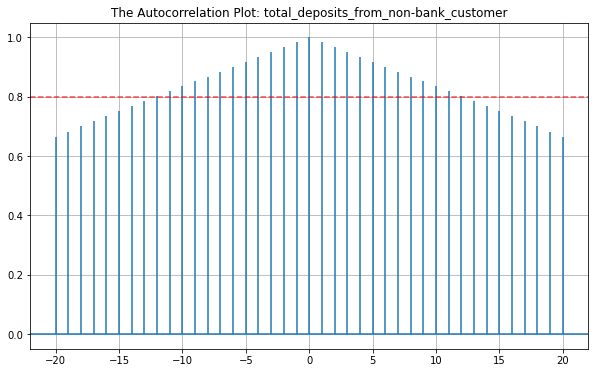

In [8]:
plt.figure(figsize=(10, 6))
plt.title(f"The Autocorrelation Plot: {Y_COL_NAME}")
plt.acorr(insample_df[Y_COL_NAME], maxlags=20)
plt.axhline(y=0.8, color="r", linestyle="--", alpha=0.7)
print("The Autocorrelation plot for the total deposit is:")
plt.grid(True)
plt.show()

In [9]:
# Add Lag columns to full dataframe, according to autocorrelation

full_lag_df = full_df.copy()

for i in range(1, 13):  # add 3 years lag
    full_lag_df[f"y_lag_{i}"] = full_lag_df[Y_COL_NAME].shift(i)

full_lag_df.head()

insample_lag_df = full_lag_df.iloc[:INSAMPLE_ROWS]  # contain nan values
insample_lag_df = insample_lag_df.dropna()  # remove nan values
outsample_lag_df = full_lag_df.iloc[-OUTSAMPLE_ROWS:]


print(insample_lag_df.shape)
print(outsample_lag_df.shape)

(92, 37)
(12, 37)


# 1. Linear Model

## 1.1 Simple Linear Model

In [10]:
SLR_df = insample_lag_df.copy()

print(SLR_df.shape)

(92, 37)


- For each single variable, build a simple linear regression model (excluding nan-value rows), collect corresponding metrics.

In [11]:
X = SLR_df.iloc[:, 2:].copy()

y = SLR_df[Y_COL_NAME].copy()

SLR_analysis_res_df = get_SLR_analysis_results(X, y)

print("================ SLR result ===================")
print("Shape of simple linear model", SLR_analysis_res_df.shape)

# SLR_analysis_res_df

================ SLR result ===================
Shape of simple linear model (35, 13)


In [12]:
# create short name conversion for each variable

X_to_alias_dict = {k: f"V_{i+1}" for (i, k) in enumerate(X.columns)}
alias_to_X_dict = {v: k for k, v in X_to_alias_dict.items()}

### Plot Bar chart of R-squared for simple linear regression  

The bar chart has shown that **Vxxx** has lowest R-squared metric for simple linear regression.   
Correspondingly, **Vxx** got relatively higher p-values.  

- [sns color palettee guide](https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f)

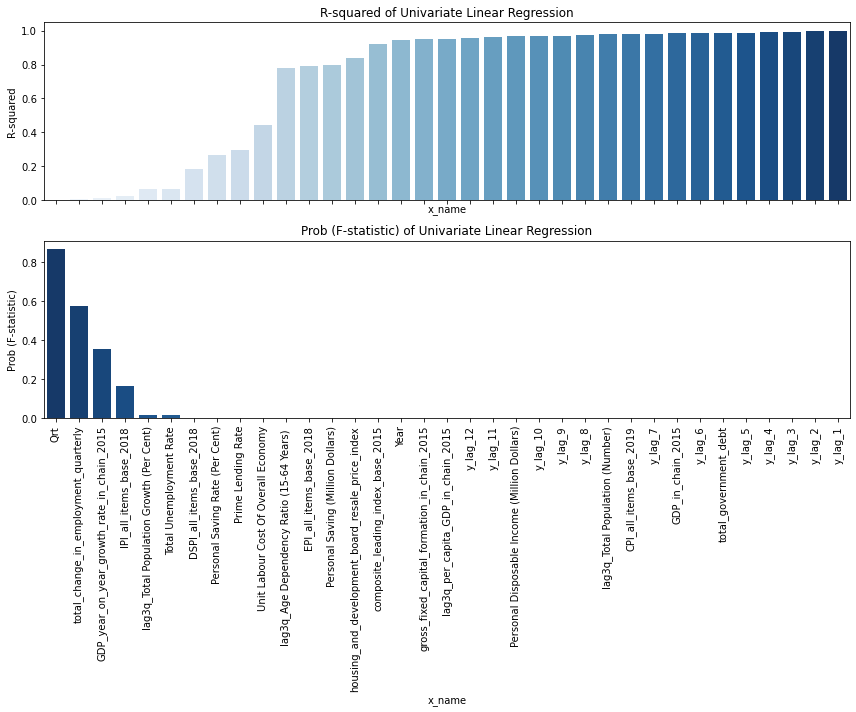

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 10))
ax1, ax2 = axs.flat
plt.xticks(rotation=90)


num_colors = SLR_analysis_res_df.shape[0]

#### Plot R-squared ####
## color follow the R-squared value

pal = sns.color_palette("Blues", n_colors=num_colors)
pal_r = sns.color_palette("Blues_r", n_colors=num_colors)


rank = (
    SLR_analysis_res_df["R-squared"].argsort().argsort()
)  # http://stackoverflow.com/a/6266510/1628638


plot1 = sns.barplot(
    ax=ax1,
    x="x_name",
    y="R-squared",
    data=SLR_analysis_res_df,
    palette=pal,
    order=SLR_analysis_res_df.sort_values("R-squared")["x_name"],
)

ax1.set_title("R-squared of Univariate Linear Regression")

#### Plot p-values ####


plot2 = sns.barplot(
    ax=ax2,
    x="x_name",
    y="Prob (F-statistic)",
    data=SLR_analysis_res_df,
    palette=pal_r,
    order=SLR_analysis_res_df.sort_values("R-squared")["x_name"],
)

ax2.set_title("Prob (F-statistic) of Univariate Linear Regression")

plt.tight_layout()
plt.savefig("./output/linear_model/univariate_LR.png")
plt.show()

### Use best univariate model on test dataset

0 Model                     Dependent Variable              Date  \
1   OLS  total_deposits_from_non-bank_customer  2022-09-21 17:33   

0 No. Observations Df Model Df Residuals R-squared Adj. R-squared        AIC  \
1               92        3           88     0.999          0.999  2022.4070   

0        BIC  ... train_MPE train_MAPE     test_RMSE   test_R2  test_MPE_1y  \
1  2032.4941  ...  0.001096   0.013043  29303.617353  0.965404     0.000611   

0  test_MPE_2y  test_MPE_3y  test_MAPE_1y  test_MAPE_2y  test_MAPE_3y  
1    -0.002614    -0.004554      0.003306      0.005655      0.009692  

[1 rows x 26 columns]

Data Series   type     real_y        pred_y      residual
12      1995 1Q  train   300190.7  3.047688e+05   4578.101259
13      1995 2Q  train   309114.8  3.111001e+05   1985.320747
14      1995 3Q  train   311506.0  3.199173e+05   8411.325399
15      1995 4Q  train   319829.3  3.194763e+05   -352.952327
16      1996 1Q  train   330260.1  3.297185e+05   -541.581256
..          ...    ...        ...           ...           ...
111     2019 4Q   test  2042985.9  2.043351e+06    364.990675
112     2020 1Q   test  2108964.4  2.069041e+06 -39923.022121
113     2020 2Q   test  2222162.2  2.151540e+06 -70622.687763
114     2020 3Q   test  2248359.8  2.290324e+06  41964.596530
115     2020 4Q   test  2286992.5  2.283138e+06  -3854.317124

[104 rows x 5 columns]

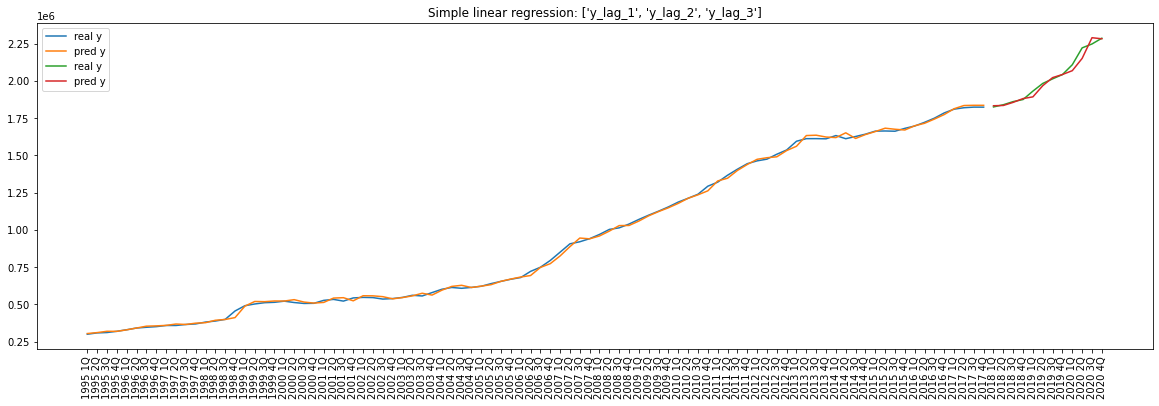

In [14]:
def save_model_to_pickle(
    model_class, insample_data, outsample_data, selected_X_names, y_name
):

    # train model
    current_train_X = insample_data[selected_X_names]
    current_train_y = insample_data[y_name]

    model = model_class(current_train_X, current_train_y)
    current_train_predict_y = model.predict(current_train_X)

    # eval
    metrics_df = model.get_train_eval()
    train_rmse = metrics_df["train_RMSE"]
    train_r2 = metrics_df["train_R2"]

    # test dataset
    current_test_X = outsample_data[selected_X_names]
    current_test_y = outsample_data[y_name]
    current_test_predict_y = model.predict(current_test_X)

    metrics_df["test_RMSE"] = RMSE(current_test_y, current_test_predict_y)
    metrics_df["test_R2"] = R2(current_test_y, current_test_predict_y)
    metrics_df["test_MPE_1y"] = MPE(current_test_y[:4], current_test_predict_y[:4])
    metrics_df["test_MPE_2y"] = MPE(current_test_y[:8], current_test_predict_y[:8])
    metrics_df["test_MPE_3y"] = MPE(current_test_y[:12], current_test_predict_y[:12])
    metrics_df["test_MAPE_1y"] = MAPE(current_test_y[:4], current_test_predict_y[:4])
    metrics_df["test_MAPE_2y"] = MAPE(current_test_y[:8], current_test_predict_y[:8])
    metrics_df["test_MAPE_3y"] = MAPE(current_test_y[:12], current_test_predict_y[:12])

    # train

    train_y_df = insample_data[["Data Series"]].copy()
    train_y_df["type"] = ["train"] * train_y_df.shape[0]
    train_y_df["real_y"] = current_train_y
    train_y_df["pred_y"] = current_train_predict_y
    train_y_df["residual"] = current_train_predict_y - current_train_y

    # test
    test_y_df = outsample_data[["Data Series"]].copy()
    test_y_df["type"] = ["test"] * test_y_df.shape[0]
    test_y_df["real_y"] = current_test_y
    test_y_df["pred_y"] = current_test_predict_y
    test_y_df["residual"] = current_test_predict_y - current_test_y

    y_df = pd.concat([train_y_df, test_y_df])

    display(metrics_df)

    display(y_df)
    
    return metrics_df, y_df

    # plot
    plt.figure(figsize=(20, 6))
    plt.title(f"Simple linear regression: {selected_X_names}")
    plt.xticks(rotation=90)
    plt.plot(train_y_df["Data Series"], train_y_df["real_y"], label="real y")
    plt.plot(train_y_df["Data Series"], train_y_df["pred_y"], label="pred y")
    plt.plot(test_y_df["Data Series"], test_y_df["real_y"], label="real y")
    plt.plot(test_y_df["Data Series"], test_y_df["pred_y"], label="pred y")
    plt.legend()
    plt.show()


save_model_to_pickle(
    MyLR,
    insample_lag_df,
    outsample_lag_df,
    ["y_lag_1", "y_lag_2", "y_lag_3"],
    Y_COL_NAME,
)

## 1.2 Multiple Linear Model  

- [Cross Validation in Machine Learning using StatsModels and Sklearn with Logistic Regression Example](https://medium.com/analytics-vidhya/cross-validation-in-machine-learning-using-python-4d0f335bec83)  
- [How to Selecting Predictors](https://otexts.com/fpp2/selecting-predictors.html)  
- [statsmodel wrapper for sklearn cross-validation](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible)

In [ ]:
MLR_df = insample_lag_df.copy()

### 1.2.1 Multiple Linear Regression: all variables, feature importance measured by **coefficient**.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
normalized_MLR_df = min_max_scaler.fit_transform(MLR_df.iloc[:, 1:])


# normalized before linear regression since coefficient will be used as feature importance
X = normalized_MLR_df[:, 1:]
y = normalized_MLR_df[:, 0]

## create alias for independent variables

sk_LR_model = LinearRegression()
# fit the model
sk_LR_model.fit(X, y)
# get importance
importance = sk_LR_model.coef_

importance

In [ ]:
x_labels = MLR_df.columns[2:]
x = range(len(importance))

temp_df = pd.DataFrame([x_labels, importance]).T
temp_df.columns = ["x_name", "coef"]


plt.figure(figsize=(12, 6))
plt.title("Multiple linear regression: feature importance by coefficient", fontsize=16)

pal = sns.diverging_palette(240, 10, n=SLR_analysis_res_df.shape[0])

rank = np.abs(importance).argsort().argsort()
plt.xticks(rotation=90)

plot = sns.barplot(
    x="x_name",
    y="coef",
    data=temp_df,
    # palette=np.array(pal)[rank],
    palette=pal,
    order=temp_df.sort_values("coef")["x_name"],
)

plt.savefig("./output/linear_model/multivariate_LR_feature_importance")
plt.show()

In [ ]:
# current_train_X = insample_lag_df[["y_lag_1"]]
# current_train_y = insample_lag_df[Y_COL_NAME]

# mySLR = MyLR(train_X=current_train_X, train_y=current_train_y)
# metrics_df = mySLR.get_train_eval()
# display(metrics_df)

# train_rmse = RMSE(current_train_y, mySLR.train_predict_y)
# train_r2 = float(metrics_df["R-squared"].values[0])


# test dataset
current_test_X = outsample_lag_df.iloc[:, 2:].values
current_test_y = outsample_lag_df[Y_COL_NAME].values
current_test_predict_y = sk_LR_model.predict(X=current_test_X)


test_rmse = RMSE(current_test_y, current_test_predict_y)
test_r2 = R2(current_test_y, current_test_predict_y)

print("", train_rmse, train_r2, test_rmse, test_r2)


temp_df = pd.DataFrame([current_test_y, current_test_predict_y]).T
temp_df.columns = ["y", "fit_y"]
temp_df["diff"] = temp_df["fit_y"] - temp_df["y"]

display(temp_df)

# display(temp_df)

plt.figure(figsize=(10, 6))
plt.title("Multivariate linear regression: all features")
plt.xticks(rotation=90)
plt.plot(outsample_lag_df["Data Series"], temp_df["y"], label="real y")
plt.plot(outsample_lag_df["Data Series"], temp_df["fit_y"], label="fitted y")
plt.legend()
plt.show()

### 1.2.2 Stepwise Regression: Backward elimination  

- [metrics string](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [ ]:
#### using all features
y_name = Y_COL_NAME
x_names = list(MLR_df.columns[2:])

lr_model = LinearRegression()
res_dict = get_cv_results(lr_model, MLR_df, y_name, x_names)
res_df = dict_to_dataframe(res_dict)

res_df

In [ ]:
y_name = Y_COL_NAME
current_x_columns = list(MLR_df.columns[2:])
k = len(current_x_columns)
criteria_metric = "test_MAPE"

# record best model for k, k = 1,2,...,K
best_k_df_ls = []

# a linear regression model
lr_model = LinearRegression()

### add model using all variables first
print(
    f"============================ Feature Subset Size: {k} ================================="
)
# print(f"number of candidates: 1")
cv_eval_df = get_cv_results(lr_model, MLR_df, y_name, list(current_x_columns))
cv_eval_df["columns"] = str(list(current_x_columns))
cv_eval_df["subset_size"] = k
cv_eval_df["removed"] = "None"
best_k_df_ls.append(dict_to_dataframe(cv_eval_df))


# backwards elimination
while k > 1:

    print(
        f"============================ Feature Subset Size: {k-1} ================================="
    )

    # 1. get all (k-1) combinations
    current_x_combination = select_k(current_x_columns, k - 1)

    # 2. get evaluation metrics for each subset
    temp_eval_ls = []
    for current_x in current_x_combination:

        cv_eval_df = get_cv_results(lr_model, MLR_df, y_name, list(current_x))

        cv_eval_df["columns"] = str(list(current_x))
        cv_eval_df["subset_size"] = k - 1

        temp_eval_ls.append(dict_to_dataframe(cv_eval_df))

    # summary of all (k-1) models
    temp_eval_df = pd.concat(temp_eval_ls)

    # 3. get the one with maximum metric value
    best_k_df = temp_eval_df[
        temp_eval_df[criteria_metric] == temp_eval_df[criteria_metric].max()
    ].copy()

    # 4. get the best (k-1) x_names
    best_k_columns = listStr_to_list(best_k_df["columns"].values[0])

    # 5. record the feature removed for this round
    removed = [x for x in current_x_columns if x not in best_k_columns]
    best_k_df["removed"] = removed

    # 6. record best model for this round
    best_k_df_ls.append(best_k_df)

    # 7. enter next round
    current_x_columns = best_k_columns
    k = k - 1


best_k_summary = pd.concat(best_k_df_ls).reset_index(drop=True)

display(best_k_summary)

- Plot evaluation metrics for best-k subset models

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
axs = axs.flat

# plt.suptitle("Backwards Elimination Process", fontsize=20)

train_ls = ["train_RMSE", "train_R2", "train_MAPE"]
test_ls = ["test_RMSE", "test_R2", "test_MAPE"]

for i in range(len(train_ls)):

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[train_ls[i]],
        marker="o",
        alpha=0.75,
        label="train",
    )

    axs[i].plot(
        best_k_summary["subset_size"],
        best_k_summary[test_ls[i]],
        marker="^",
        alpha=0.75,
        label="test",
    )

    axs[i].set_xlabel("subset_size")
    axs[i].set_ylabel(train_ls[i].split("_")[-1])
    axs[i].set_title(f'{train_ls[i].split("_")[-1]} vs. Subset Size', fontsize=16)
    axs[i].legend(loc="upper right")

plt.savefig("./output/linear_model/multivariate_LR_backwards_elimination.png")
plt.show()

- Get the best subset at turning point, evaluate it on the outsample dataset

In [ ]:
# best_k_summary.iloc[5, :]["columns"]

x_cols = listStr_to_list(best_k_summary.iloc[5, :]["columns"])


current_train_X = insample_lag_df[x_cols]
current_train_y = insample_lag_df[Y_COL_NAME]

mySLR = MyLR(train_X=current_train_X, train_y=current_train_y)
metrics_df = mySLR.get_train_eval()
display(metrics_df)

train_rmse = RMSE(current_train_y, mySLR.train_predict_y)
train_r2 = float(metrics_df["R-squared"].values[0])


# test dataset
current_test_X = outsample_lag_df[x_cols]
current_test_y = outsample_lag_df[Y_COL_NAME]
current_test_predict_y = mySLR.predict(X=current_test_X)

test_rmse = RMSE(current_test_y, current_test_predict_y)
test_r2 = R2(current_test_y, current_test_predict_y)

print("", train_rmse, train_r2, test_rmse, test_r2)

In [ ]:
temp_df = pd.DataFrame([current_test_y, current_test_predict_y]).T
temp_df.columns = ["y", "fit_y"]
temp_df["diff"] = temp_df["fit_y"] - temp_df["y"]

temp_df

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(outsample_lag_df["Data Series"], temp_df["y"])
plt.plot(outsample_lag_df["Data Series"], temp_df["fit_y"])
plt.show()

### 1.2.3 Feature Selection by Model: Elasticnet

In [ ]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNetCV

In [ ]:
# define model
# model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
# evaluate model

# define model
ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

model = ElasticNetCV(l1_ratio=ratios, cv=cv)
# fit model
model.fit(X, y)
# summarize chosen configuration
print("alpha: %f" % model.alpha_)
print("l1_ratio_: %f" % model.l1_ratio_)

model.coef_

predict_y = model.predict(X)


MAPE(y, predict_y)

In [ ]:
### test code

# best_k_summary.iloc[5, :]["columns"]

current_test_y = outsample_lag_df[Y_COL_NAME]
current_test_predict_y = model.predict(outsample_lag_df.iloc[:, 2:])


temp_df = pd.DataFrame([list(current_test_y), current_test_predict_y]).T
temp_df.columns = ["y", "fit_y"]
temp_df["diff"] = temp_df["fit_y"] - temp_df["y"]

display(temp_df)

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.plot(outsample_lag_df["Data Series"], temp_df["y"])
plt.plot(outsample_lag_df["Data Series"], temp_df["fit_y"])
plt.show()

In [ ]:
importance = model.coef_

x_labels = ["V_" + str(i + 1) for i in range(len(importance))]
x = range(len(importance))

temp_df = pd.DataFrame([x_labels, importance]).T
temp_df.columns = ["x_alias", "coef"]


plt.figure(figsize=(10, 6))
plt.title("Multiple linear regression: feature importance by coefficient", fontsize=16)

pal = sns.color_palette("Blues_d", SLR_analysis_res_df.shape[0])
rank = np.abs(importance).argsort().argsort()
plt.xticks(rotation=90)

plot2 = sns.barplot(
    x="x_alias",
    y="coef",
    data=temp_df,
    # palette=np.array(pal)[rank],
    palette=pal,
    order=temp_df.sort_values("coef")["x_alias"],
)

plt.savefig("./output/linear_model/multivariate_LR_feature_importance")
plt.show()